In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual

%config InlineBackend.figure_format = 'retina'

/local/tspriggs/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
# functions
#Read in Wavelength and slice to region of interest.
data = ascii.read("M87_data/wavelength.txt", names=["wavelength"])
wavelength = np.array(data["wavelength"])

y_data = 318
x_data = 315
# Open Fits file and assign to raw_data
hdulist = fits.open("M87_data/M87_rescube.fits")
raw_data_list = hdulist[0].data
# Reshape into a datacube 318x315x271

#raw_data_list = raw_data.reshape((y_data* x_data, len(wavelength)))

hdr = hdulist[0].header

In [22]:
def Gaussian_1D_res(params, x, data, error, spec_num):
    Amp = params["Amp"]
    mean = params["mean"]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]
     
    Gauss_std = FWHM / 2.35482
    model = ((Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - mean)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / Gauss_std**2.))
    
    list_of_rN[spec_num] = np.std(data - model)
    list_of_residuals[spec_num] = data - model
    
    return (data - model) / error


params = Parameters()
params.add("Amp",value=50., min=0.001, max=300.)
params.add("mean", value=5005., min=4970., max=5040.)
params.add("FWHM", value=2.81, vary=False) # LSF
params.add("Gauss_bkg", value=0.001, min=-500., max=500.)
params.add("Gauss_grad", value=0.001)

list_of_std = np.array([np.abs(np.std(spec)) for spec in raw_data_list])
input_errors = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0,len(list_of_std))]

list_of_rN = np.zeros(len(raw_data_list))
list_of_residuals = np.zeros((len(raw_data_list),len(wavelength)))
list_of_residuals_from_fitter = np.zeros((len(raw_data_list),len(wavelength)))
best_fit_A = np.zeros((len(raw_data_list),2))
best_fit_mean = np.zeros((len(raw_data_list),2))

In [23]:
for i,spectra in enumerate(raw_data_list):
    results = minimize(Gaussian_1D_res, params, args=(wavelength, spectra, input_errors[i], i), nan_policy="propagate")
    best_fit_A[i] = [results.params["Amp"], results.params["Amp"].stderr]
    best_fit_mean[i] = [results.params["mean"], results.params["mean"].stderr]
    list_of_residuals_from_fitter[i] = results.residual

In [24]:
gauss_A = [A[0] for A in best_fit_A]
A_err = [A[1] for A in best_fit_A]

A_rN = np.array([A / rN for A,rN in zip(gauss_A, list_of_rN)])
A_rN_shape = A_rN.reshape(y_data,x_data)

Gauss_F = np.array(gauss_A) * np.sqrt(2*np.pi) * 1.19
Gauss_F_shape = Gauss_F.reshape(y_data, x_data)

In [15]:
np.save("exported_data/M87/A_rN", A_rN)
np.save("exported_data/M87/gauss_A", gauss_A)
np.save("exported_data/M87/gauss_A_err", A_err)
np.save("exported_data/M87/gauss_F", Gauss_F)

In [16]:
A_rN = np.load("exported_data/M87/A_rN.npy")
A_rN_shape = A_rN.reshape(y_data,x_data)

gauss_A = np.load("exported_data/M87/gauss_A.npy")
gauss_A_shape = np.array(gauss_A).reshape(y_data,x_data)

gauss_A_err = np.load("exported_data/M87/gauss_A_err.npy")
gauss_A_err_shape = gauss_A_err.reshape(y_data, x_data)

gauss_F = np.load("exported_data/M87/gauss_F.npy")
gauss_F_shape = np.array(gauss_F).reshape(y_data,x_data)


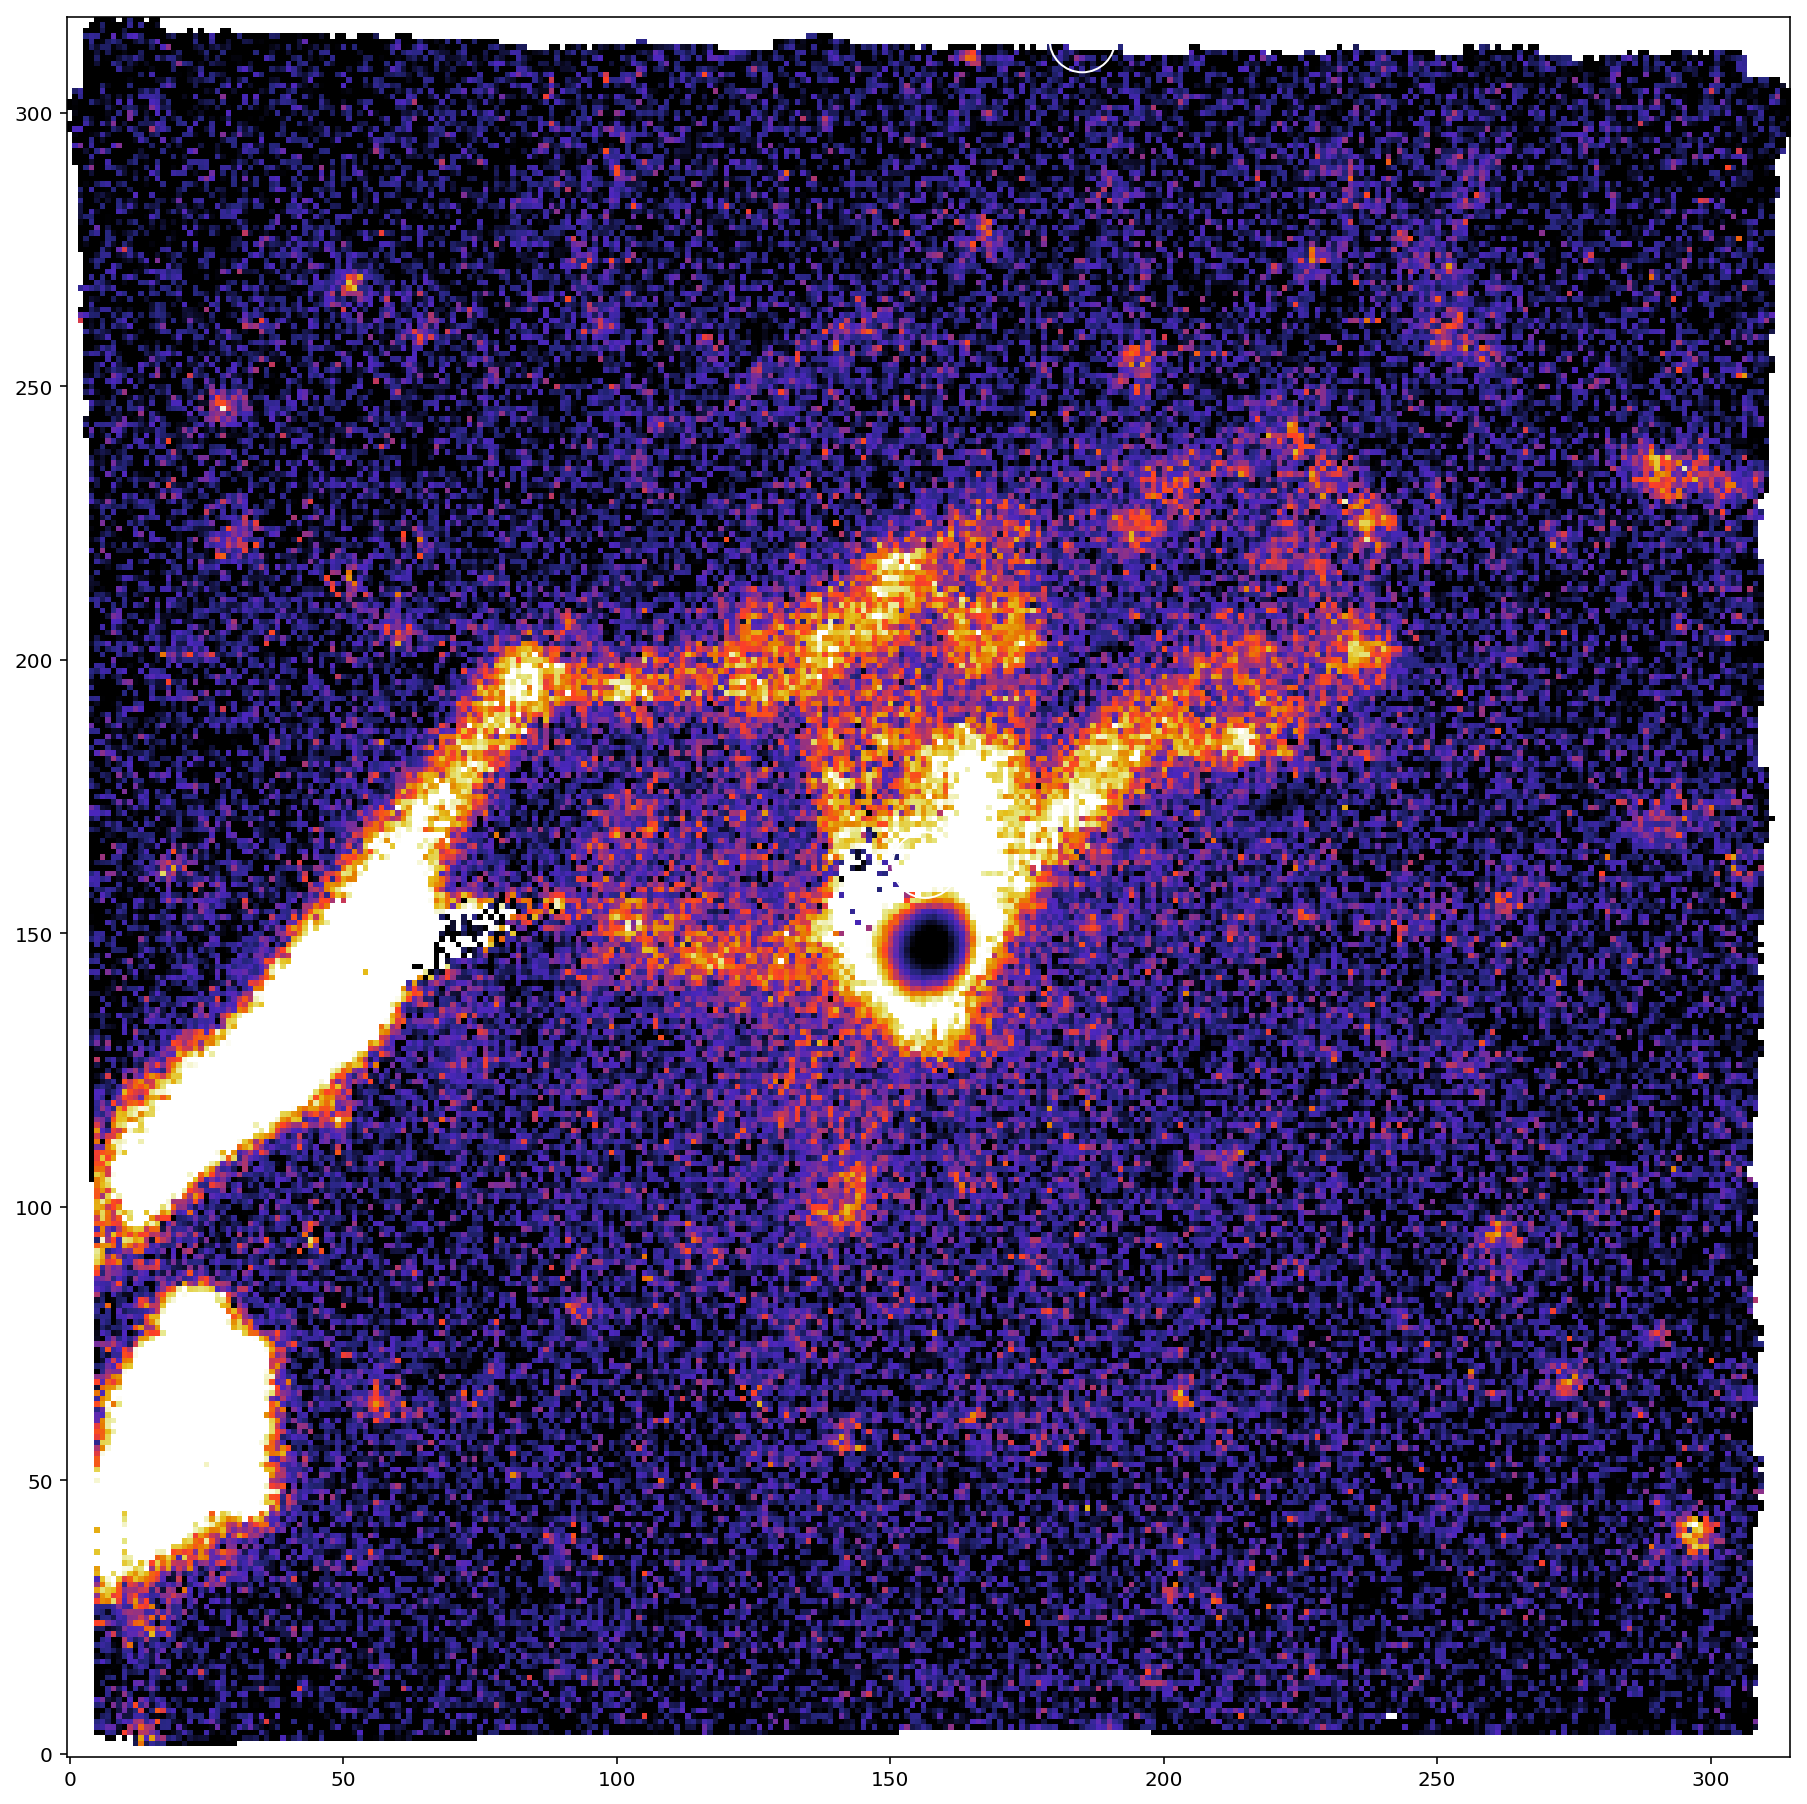

In [17]:
import sep
from photutils import CircularAperture
objects = sep.extract(Gauss_F_shape, thresh=3.2, clean=False )
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=6)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=1., vmax=7.)
apertures.plot(color="white")

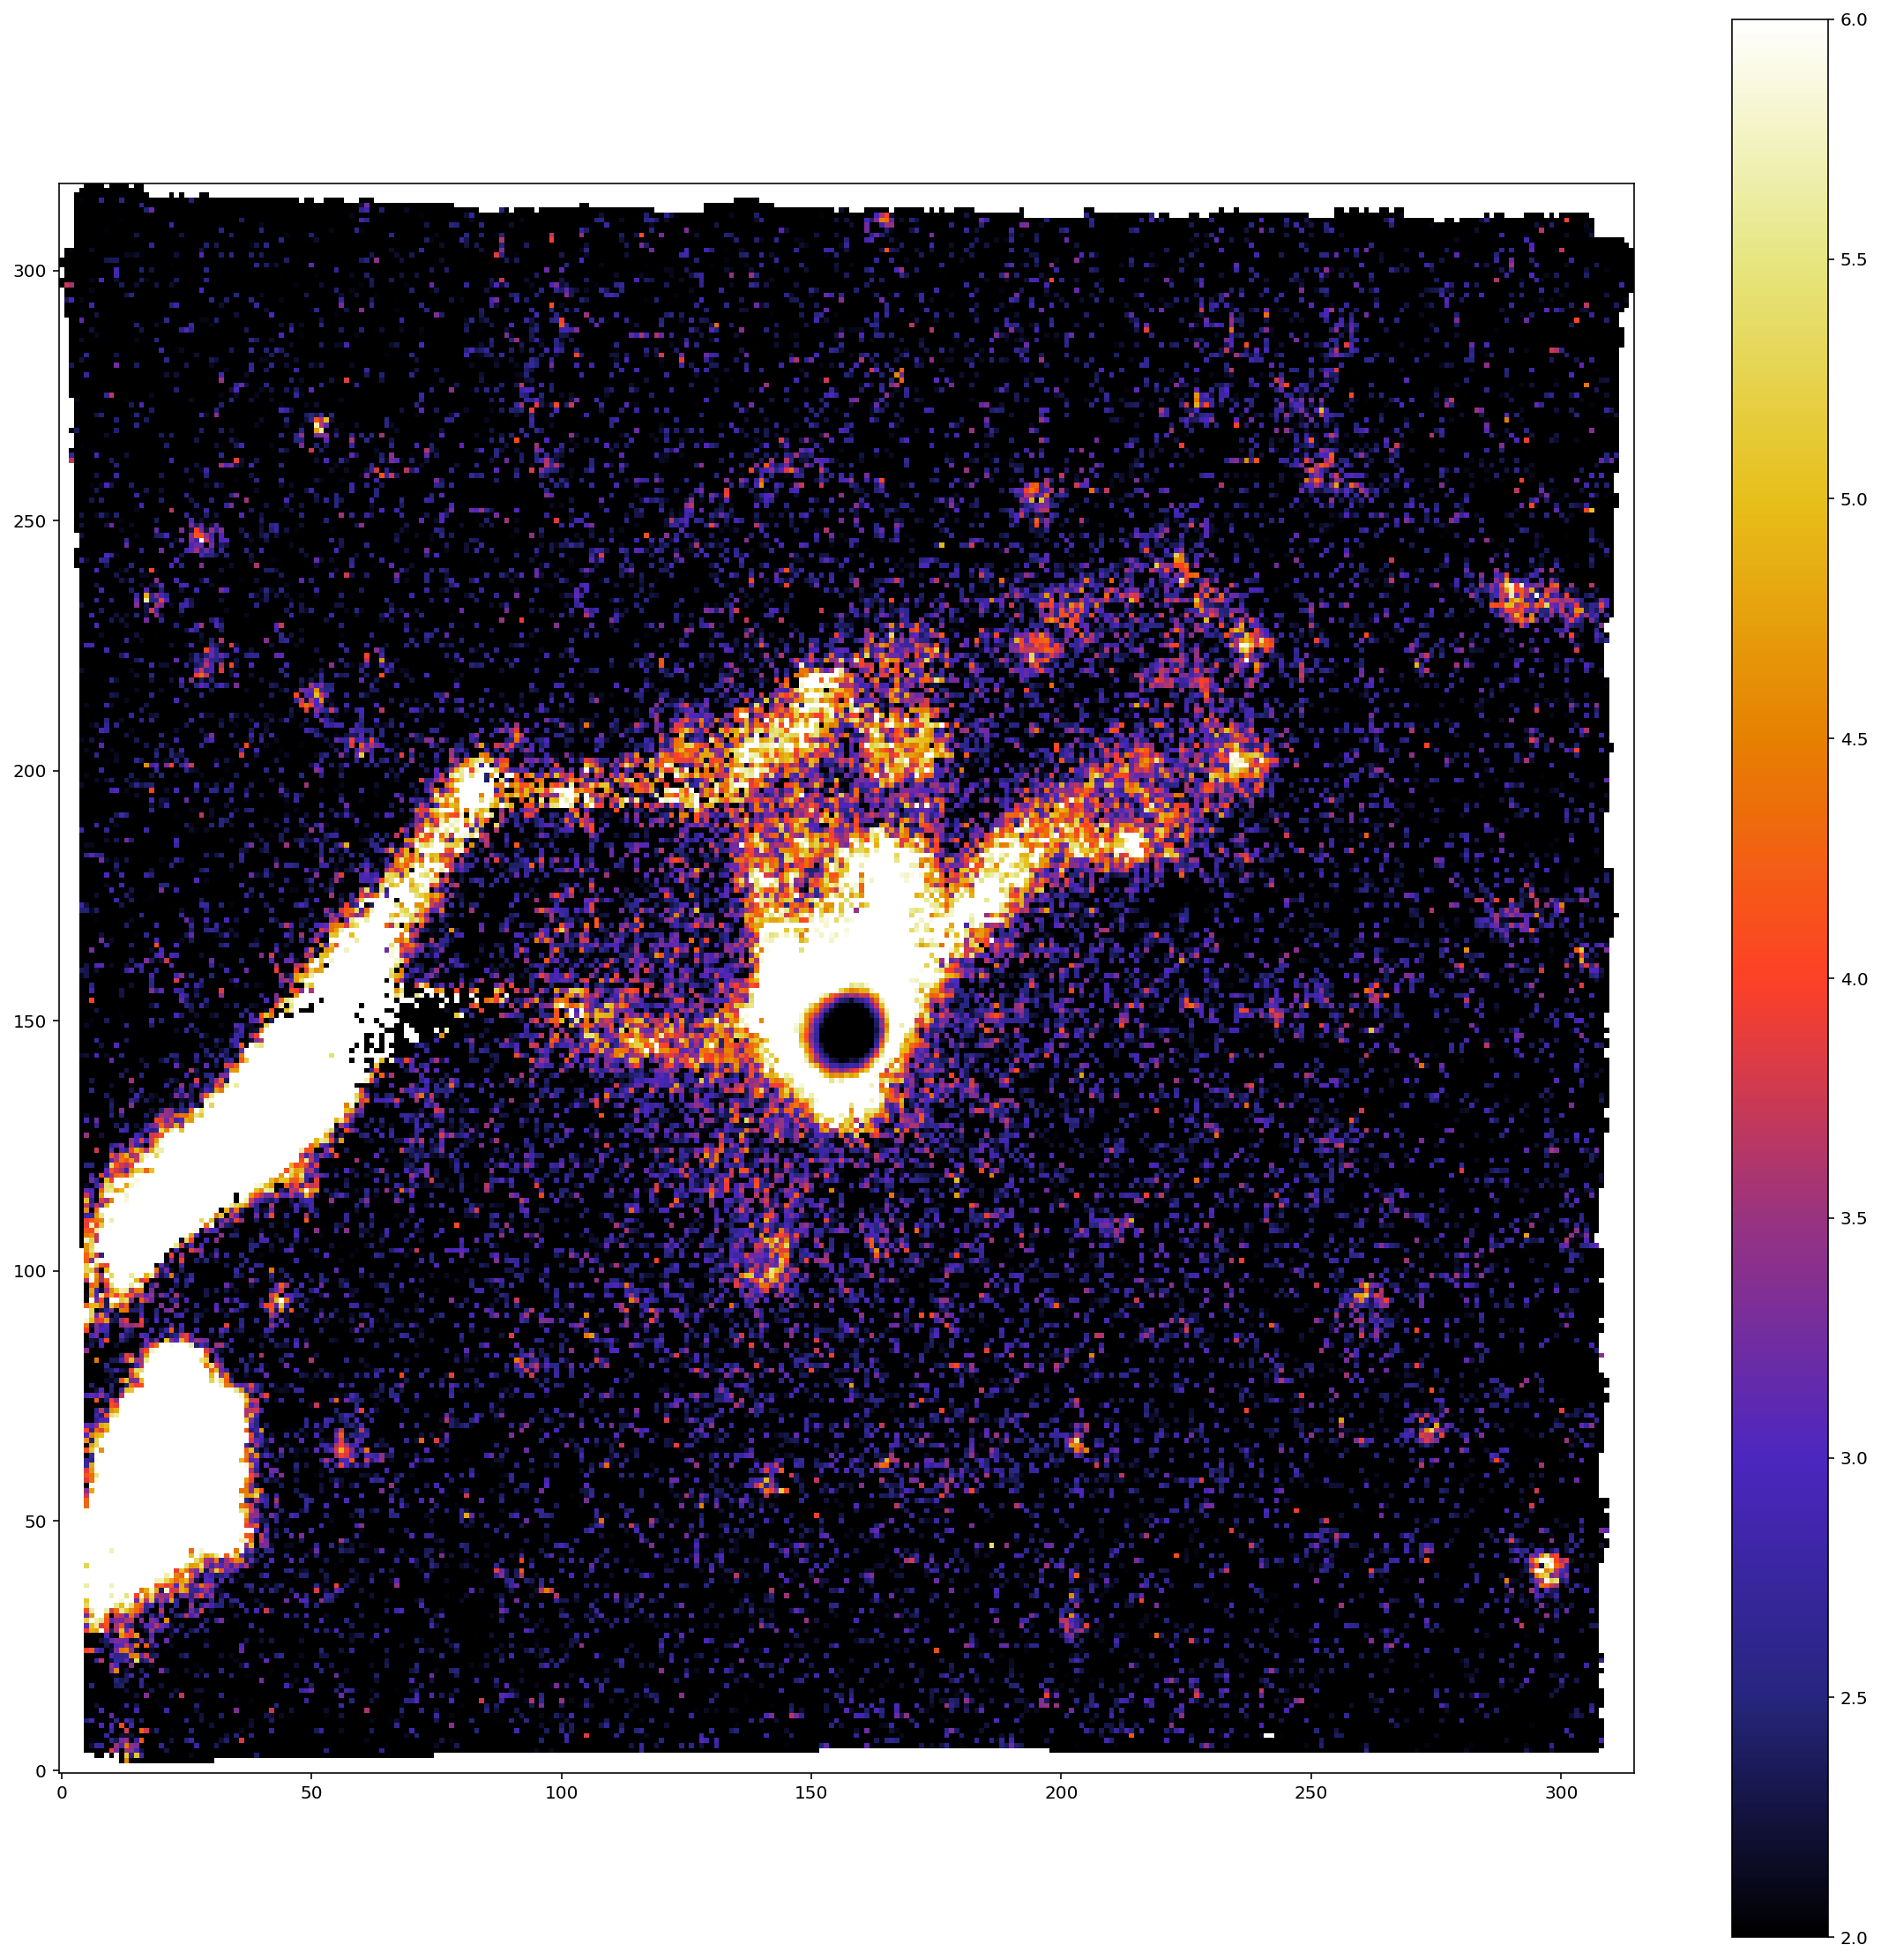

In [27]:
plt.figure(2,figsize=(20,20))
plt.imshow(A_rN_shape,origin="lower", cmap="CMRmap", vmin=2, vmax=6)
cb = plt.colorbar()
#plt.savefig("Plots/M87_A_rN_tmp.png")